# Report for Ratings-Results

This report can be used to get an overview on the state of the evaluation.<br/>
It pulls the current ratings from firebase and uses different aggregations in order to create a number of visualizations and statistics.

### Pulling the data

In [58]:
from report import create_report_files
pull_data = True

if pull_data:
    create_report_files(
        "../../keys/gs-on-a-budget-firebase-adminsdk-63ws0-509fffaf5f.json",
        "ratings-v5.xlsx",
        "pairs-v5.xlsx",
    )

### Loading and displaying the raw data

In [59]:
import pandas as pd

pairs = pd.read_excel("./pairs-v5.xlsx")
pairs.columns.values

array(['Unnamed: 0', 'rotation', 'model_2', 'initial_distance', 'fov_y',
       'n_ratings', 'high_detail', 'technique_1', 'model_1',
       'technique_2', 'size', 'dataset_name', 'position', 'dataset',
       'aspect', 'id'], dtype=object)

In [60]:
ratings = pd.read_excel("./ratings-v5.xlsx")
ratings["timestamp"] = ratings["timestamp"].apply(pd.to_datetime)
ratings.columns.values

array(['Unnamed: 0', 'technique_2', 'size', 'rating', 'dataset',
       'user_id', 'pair_id', 'technique_1', 'timestamp', 'id', 'rating_1',
       'rating_2'], dtype=object)

### How many ratings are there per pair?

In [61]:
ratings_count_computed = ratings.groupby("pair_id")["id"].count()
df_ratings_count_computed = pd.DataFrame.from_dict({
    "pair_id": ratings_count_computed.index,
    "count": ratings_count_computed.values
}).sort_values("count", ascending=False)
df_ratings_count_computed

,pair_id,count
8,2kRptcQx5PSo54pmymCi,3
27,AXCAW0Sac9plQWEH2pi4,3
97,sGEqUwHWXm4uNV50fIul,3
14,4F14IrWf2S6Uwzm7ajl4,2
13,4DabfkFLBojKxKol8UQf,2
...,...,...
109,wbJENHoedilRBPklpO3w,1
111,xh9segHQ5UyJB9dih4b0,1
110,x4yFyy0x8GgtgYalqlpa,1
113,xqxTCtx1hcwpQzoIq86W,1


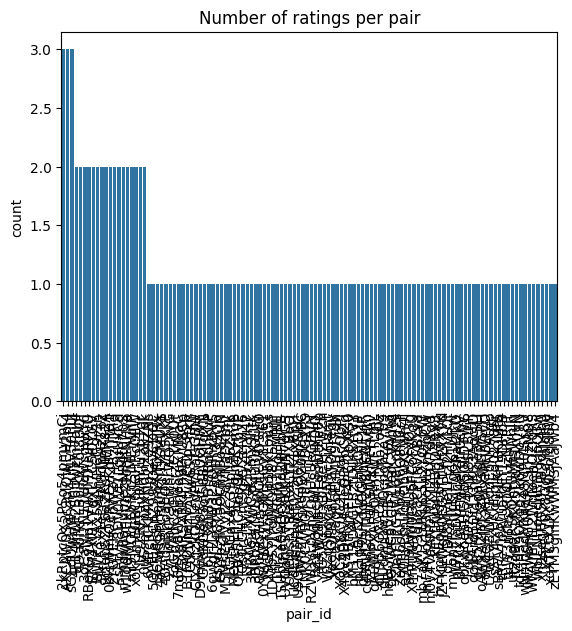

In [62]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(df_ratings_count_computed, x="pair_id", y="count")
plt.xticks(rotation=90)
plt.title("Number of ratings per pair")
plt.show()

In [63]:
# Check what percentage of pairs has been covered once
print(f"{df_ratings_count_computed.shape[0]}/{pairs.shape[0]} pairs have been covered. Thats {round(df_ratings_count_computed.shape[0] / pairs.shape[0] * 100, 2)}%.")

116/189 pairs have been covered. Thats 61.38%.


In [64]:
# sanity check from ratings side if all n_ratings are actually covered by actual ratings
for idx, row in pairs.iterrows():
    if row["n_ratings"] >= 1:
        if id in ratings_count_computed:
            if not (ratings_count_computed[id] == row["n_ratings"]):
                print(f"Error! pair \"{row['id']}\" had different n_ratings than actual rating entities {row['n_ratings']} != {ratings_count_computed[id]}")
        else:
            print(f"Error! pair \"{row['id']}\" had different n_ratings than actual rating entities {row['n_ratings']} != {0}")

Error! pair "0Qbwb7Lis9pOLUVOSIrO" had different n_ratings than actual rating entities 1 != 0
Error! pair "0YwyBZxWsQpHsGv8LS61" had different n_ratings than actual rating entities 1 != 0
Error! pair "0bIsWmiOeRXEyKdMrHB1" had different n_ratings than actual rating entities 2 != 0
Error! pair "0uSshiYpzXHdIn1okZsk" had different n_ratings than actual rating entities 2 != 0
Error! pair "1DMpSYJYgWlOR38X57hm" had different n_ratings than actual rating entities 1 != 0
Error! pair "1SUpmaSAQQNMdD8FibPB" had different n_ratings than actual rating entities 1 != 0
Error! pair "1njZxACnAGt6T5qLMRlL" had different n_ratings than actual rating entities 1 != 0
Error! pair "29sPSf4gbZUmlbkLou5s" had different n_ratings than actual rating entities 1 != 0
Error! pair "2kRptcQx5PSo54pmymCi" had different n_ratings than actual rating entities 3 != 0
Error! pair "2yLwlpCr3EttnrWODivG" had different n_ratings than actual rating entities 1 != 0
Error! pair "3BPbSeLlA1pP4U3oOUfy" had different n_ratings t

In [65]:
# sanity check to see if ratings and n_ratings actually match up
for pair_id, n_ratings in ratings_count_computed.items():
    pair = pairs[pairs["id"] == pair_id]
    if pair.shape[0] != 1:
        print(f'ERROR: pair "{pair_id}" occurs "{pair.shape[0]}" times')
    db_n_ratings = pair["n_ratings"].values[0]
    if n_ratings != db_n_ratings:
        print(
            f'ERROR: pair "{pair_id}" has {n_ratings} but ratings tracker only has {db_n_ratings}'
        )

### How many ratings per user?

In [66]:
ratings_per_user = ratings.groupby("user_id")["id"].count()
df_ratings_per_user = pd.DataFrame.from_dict(
    {"user_id": ratings_per_user.index, "count": ratings_per_user.values}
).sort_values("count", ascending=False)
df_ratings_per_user

,user_id,count
9,d8033277-b91a-4a77-8a57-77b042e1497d,31
0,0a665c40-da19-49db-ad71-f87e7af9c0d8,23
4,4ade5517-3297-49b4-a1e7-a76ae38a8327,19
2,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361,14
5,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,12
8,a7037b14-2e6d-4f7d-bac8-ed02d7df5329,6
3,450cd38d-27d8-4b1e-b397-f6aa0769f389,6
12,e5de31f2-fc40-4062-9135-3aba73149106,5
11,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f,5
10,e02cbd32-23a2-4b8e-b47f-f94d9ff7f400,5


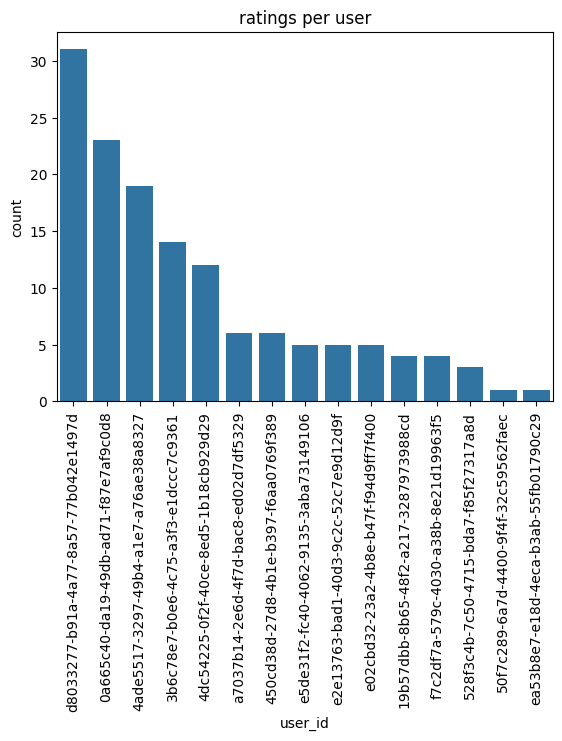

In [67]:
sns.barplot(df_ratings_per_user, x="user_id", y="count")
plt.xticks(rotation=90)
plt.title("ratings per user")
plt.show()

### How many times has every individual model been rated?

In [68]:
rating_records = []

for idx, row in ratings.iterrows():
    pair = pairs[row["pair_id"] == pairs["id"]].iloc[0]
    rating_records.append(
        {
            "model_name": str(pair["model_1"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "first",
            "user_id": row["user_id"],
        }
    )
    rating_records.append(
        {
            "model_name": str(pair["model_2"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "second",
            "user_id": row["user_id"],
        }
    )

df_ratings_per_model = pd.DataFrame.from_records(rating_records)
df_ratings_per_model

,model_name,preferred,user_id
0,eagles-truck-medium-1,True,d8033277-b91a-4a77-8a57-77b042e1497d
1,geo_gaussian-truck-medium-1,False,d8033277-b91a-4a77-8a57-77b042e1497d
2,default-truck-low-1,True,4dc54225-0f2f-40ce-8ed5-1b18cb929d29
3,eagles-truck-low-1,False,4dc54225-0f2f-40ce-8ed5-1b18cb929d29
4,mini_splatting-stump-medium-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d
...,...,...,...
273,mip_splatting-room-high-1,False,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361
274,eagles-stump-high-1,True,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
275,gaussian_pro-stump-high-1,False,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
276,mini_splatting-stump-medium-1,True,4ade5517-3297-49b4-a1e7-a76ae38a8327


In [69]:
count_ratings_per_model = df_ratings_per_model.groupby("model_name")["model_name"].count()
df_count_ratings_per_model = pd.DataFrame.from_dict({
    "model_name": count_ratings_per_model.index,
    "n_ratings": count_ratings_per_model.values,
}).sort_values("n_ratings", ascending=False)
df_count_ratings_per_model

,model_name,n_ratings
0,default-room-high-1,8
4,default-stump-low-1,8
31,geo_gaussian-stump-low-1,8
20,gaussian_pro-room-medium-1,7
26,gaussian_pro-truck-medium-1,7
...,...,...
43,mcmc-truck-low-1,2
56,mip_splatting-room-medium-1,2
24,gaussian_pro-truck-high-1,1
42,mcmc-truck-high-1,1


### Whats the just objectionable difference (JOD) for each dataset/approach/size?

In [70]:
from typing import NamedTuple
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from matplotlib import pyplot as plt


index = {
    "default": 0,
    "mcmc": 1,
    "mini_splatting": 2,
    "eagles": 3,
    "mip_splatting": 4,
    "gaussian_pro": 5,
    "geo_gaussian": 6,
}


def create_preference_matrix_from_df(df: pd.DataFrame) -> np.ndarray:
    preferences = np.zeros((7, 7), dtype=np.uint)

    for _, rating in df.iterrows():
        if rating["rating"] == "first":
            preferences[index[rating["technique_1"]]][index[rating["technique_2"]]] = (
                preferences[index[rating["technique_1"]]][index[rating["technique_2"]]]
                + 1
            )
        if rating["rating"] == "second":
            preferences[index[rating["technique_2"]]][index[rating["technique_1"]]] = (
                preferences[index[rating["technique_2"]]][index[rating["technique_1"]]]
                + 1
            )

    return preferences


# Function to calculate log-likelihood
def thurstone_log_likelihood(mu: np.ndarray, C: np.ndarray) -> float:
    n = len(mu)
    log_likelihood = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                p_ij = norm.cdf((mu[i] - mu[j]) / np.sqrt(2))
                log_likelihood += C[i, j] * np.log(
                    p_ij + 1e-9
                )  # Add a small value to avoid log(0)
    return -log_likelihood


class JodResults(NamedTuple):
    default: float
    mcmc: float
    mini_splatting: float
    eagles: float
    mip_splatting: float
    gaussian_pro: float
    geo_gaussian: float

    def to_array(self) -> np.ndarray:
        return np.array(
            [
                self.default,
                self.mcmc,
                self.mini_splatting,
                self.eagles,
                self.mip_splatting,
                self.gaussian_pro,
                self.geo_gaussian,
            ]
        )


def compute_jod(preferences: np.ndarray) -> JodResults:
    # Initial guess for latent qualities
    n_stimuli = preferences.shape[0]
    mu_init = np.zeros(n_stimuli)

    # Optimize latent scores
    result = minimize(
        thurstone_log_likelihood, mu_init, args=(preferences,), method="BFGS"
    )
    [
        default,
        mcmc,
        mini_splatting,
        eagles,
        mip_splatting,
        gaussian_pro,
        geo_gaussian,
    ] = result.x

    return JodResults(
        default,
        mcmc,
        mini_splatting,
        eagles,
        mip_splatting,
        gaussian_pro,
        geo_gaussian,
    )


def plot_jod_full() -> pd.DataFrame:
    _, axs = plt.subplots(3, 3, sharex=True, sharey=True)

    records = []

    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current_ratings = ratings[
                (ratings["size"] == size) & (ratings["dataset"] == dataset)
            ]
            preferences = create_preference_matrix_from_df(current_ratings)
            jod_results = compute_jod(preferences)

            axs[i][j].bar(index.keys(), jod_results.to_array())
            if i == 2:
                axs[i][j].tick_params(labelrotation=90)
                plt.setp(axs[i, j], xlabel=dataset)

            if j == 0:
                plt.setp(axs[i, 0], ylabel=size)

            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "default": jod_results.default,
                    "mcmc": jod_results.mcmc,
                    "mini_splatting": jod_results.mini_splatting,
                    "eagles": jod_results.eagles,
                    "mip_splatting": jod_results.mip_splatting,
                    "gaussian_pro": jod_results.gaussian_pro,
                    "geo_gaussian": jod_results.geo_gaussian,
                }
            )

    plt.tight_layout()
    plt.show()

    return pd.DataFrame.from_records(records)

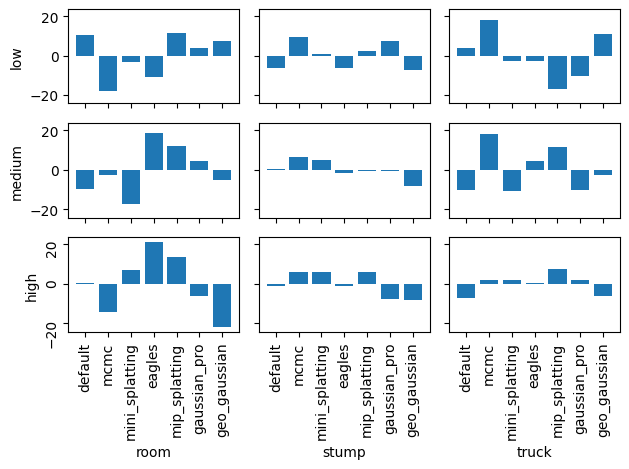

In [71]:
df_jod_full = plot_jod_full()

## Whats the JOD over time as more ratings come in?

In [72]:
def compute_jod_batched(batch_size: int) -> pd.DataFrame:
    records = []

    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current_ratings = ratings[
                (ratings["size"] == size) & (ratings["dataset"] == dataset)
            ].sort_values("timestamp", na_position="first")

            batches = [current_ratings[pd.isna(current_ratings["timestamp"])]]

            len_na = pd.isna(current_ratings["timestamp"]).sum()
            len_non_na = pd.notna(current_ratings["timestamp"]).sum()
            for i in range(0, len_non_na, batch_size):
                batches.append(
                    current_ratings.iloc[
                        0:(len_na + min(len_non_na, i + batch_size))
                    ]
                )

            for batch_idx, batch in enumerate(batches):
                preferences = create_preference_matrix_from_df(batch)
                jod_results = compute_jod(preferences)

                records.append(
                    {
                        "size": size,
                        "dataset": dataset,
                        "batch_idx": batch_idx,
                        "default": jod_results.default,
                        "mcmc": jod_results.mcmc,
                        "mini_splatting": jod_results.mini_splatting,
                        "eagles": jod_results.eagles,
                        "mip_splatting": jod_results.mip_splatting,
                        "gaussian_pro": jod_results.gaussian_pro,
                        "geo_gaussian": jod_results.geo_gaussian,
                    }
                )

    return pd.DataFrame.from_records(records)

In [73]:
#df_jod_batched_10 = compute_jod_batched(10)


In [74]:
#df_jod_batched_5 = compute_jod_batched(5)

In [75]:
df_jod_batched_3 = compute_jod_batched(3)

In [76]:
#df_jod_batched_20 = compute_jod_batched(20)

In [77]:
def plot_jod_batched(df_batched: pd.DataFrame) -> None:
    _, axs = plt.subplots(3, 3, sharex=True, sharey=True)
    lines = []
    columns = ["default", "mcmc","mini_splatting",	"eagles", "mip_splatting", "gaussian_pro", "geo_gaussian"]
    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current = df_batched[
                (df_batched["size"] == size) & (df_batched["dataset"] == dataset)
            ]
            for col in columns:
                line, = axs[i][j].plot(current["batch_idx"], current[col])
                if i == 0 and j == 0:
                    lines.append(line)
            
            if i == 2:
                axs[i][j].tick_params(labelrotation=90)
                plt.setp(axs[-1, j], xlabel=dataset)
            else:
                pass
                # axs[i][j].set_xticks(["" for _ in range(len(current))])

            if j == 0:
                plt.setp(axs[i, 0], ylabel=size)

    plt.tight_layout()
    axs[1, 2].legend(lines, columns, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

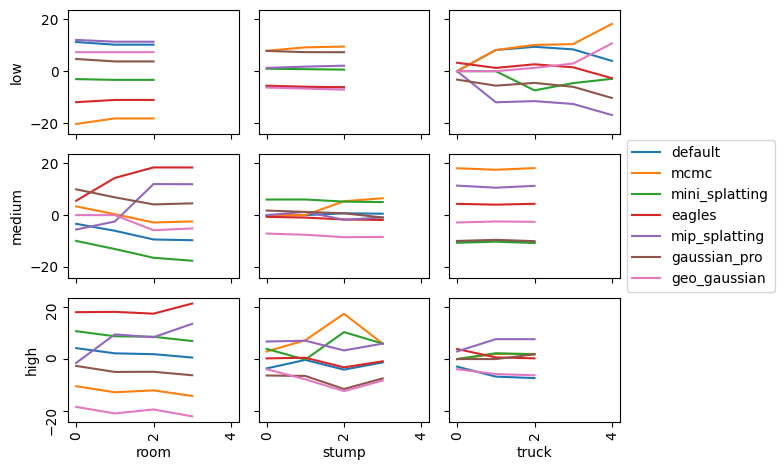

In [78]:
plot_jod_batched(df_jod_batched_3)

## Which dataset+size combination has been rated the least?

In [79]:
df_ratings_count = ratings.groupby(["dataset", "size"])["id"].count().reset_index().sort_values("id")
df_ratings_count

,dataset,size,id
6,truck,high,10
5,stump,medium,12
7,truck,low,12
1,room,low,13
2,room,medium,14
3,stump,high,16
0,room,high,20
4,stump,low,20
8,truck,medium,22


## How stable is the JOD when cross-validating?

In [105]:
from typing import Tuple
import numpy as np
import multiprocessing as mp
from sklearn.model_selection import KFold
import itertools


def cross_validate_jod_for_circumstance(tup: Tuple[int, Tuple[str, str]]) -> np.ndarray:
    k_folds, (size, dataset) = tup
    current = ratings[(ratings["size"] == size) & (ratings["dataset"] == dataset)]
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    jod_estimates = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(current)):
        train_data = current.iloc[train_idx]
        preferences = create_preference_matrix_from_df(train_data)
        jod_results = compute_jod(preferences)
        jod_estimates.append((fold_idx, jod_results))

    return size, dataset, jod_estimates


def compute_k_fold_cross_validation(k_folds: int) -> pd.DataFrame:
    num_workers = min(mp.cpu_count() - 1, 9)
    circumstances = list(
        itertools.product(["low", "medium", "high"], ["room", "stump", "truck"])
    )
    with mp.Pool(num_workers) as pool:
        results = pool.map(
            cross_validate_jod_for_circumstance,
            zip(
                [10 for _ in range(len(circumstances))],
                circumstances,
            ),
        )

    records = []

    for size, dataset, jod_estimates in results:
        for fold_idx, jod_results in jod_estimates:
            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "fold_idx": fold_idx,
                    "default": jod_results.default,
                    "mcmc": jod_results.mcmc,
                    "mini_splatting": jod_results.mini_splatting,
                    "eagles": jod_results.eagles,
                    "mip_splatting": jod_results.mip_splatting,
                    "gaussian_pro": jod_results.gaussian_pro,
                    "geo_gaussian": jod_results.geo_gaussian,
                }
            )

    return pd.DataFrame.from_records(records)


result = compute_k_fold_cross_validation(10)

In [122]:
result.groupby(["size", "dataset"]).agg(["std"])

fold_idx   default      mcmc mini_splatting    eagles  \
                    std       std       std            std       std   
size   dataset                                                         
high   room     3.02765  2.129274  4.759205       2.804280  2.835864   
       stump    3.02765  1.198975  3.635172       4.450483  1.492268   
       truck    3.02765  0.810764  0.716922       0.622721  0.721164   
low    room     3.02765  1.824806  2.179436       1.831720  3.095707   
       stump    3.02765  2.629575  1.610186       1.124815  0.991632   
       truck    3.02765  2.502065  4.345530       2.369946  2.451825   
medium room     3.02765  1.971348  2.755169       2.484070  2.577862   
       stump    3.02765  0.471952  0.500247       0.549919  0.560613   
       truck    3.02765  2.962708  3.051950       4.237687  1.141465   

               mip_splatting gaussian_pro geo_gaussian  
                         std          std          std  
size   dataset                                          
high   room         2.601353     1.942869     6.105795  
       stump        3.782550     2.766032     2.245812  
       truck        1.907864     0.622721     0.549222  
low    room         1.922084     2.677014     1.077764  
       stump        1.298561     1.741188     3.529421  
       truck        3.754139     4.213583     2.942495  
medium room         4.097850     1.845471     2.338769  
       stump        0.735055     0.820709     0.636967  
       truck        2.887876     2.311607     0.666425

## How stable is the ranking according to the JOD across all the different circustances and models?

In [156]:
# overall rank stability
ranks = result[
    [
        "default",
        "mcmc",
        "mini_splatting",
        "eagles",
        "mip_splatting",
        "gaussian_pro",
        "geo_gaussian",
    ]
].rank(axis=1, ascending=False)

rank_counts = ranks.apply(pd.Series.value_counts, axis=0).fillna(0)
df_rank_overall = (rank_counts / ranks.shape[0] * 100).apply(round)

<Axes: >

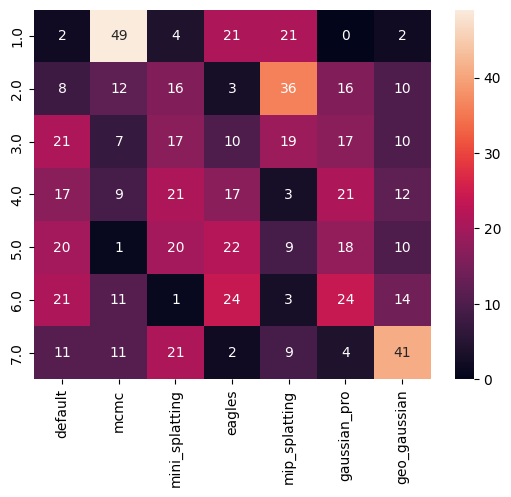

In [157]:
import seaborn as sns

sns.heatmap(df_rank_overall, annot=True)

In [170]:
def compute_rank_consistency(df_jod_cv: pd.DataFrame) -> pd.DataFrame:
    records = []

    for size in ["low", "medium", "high"]:
        for dataset in ["room", "stump", "truck"]:
            current = df_jod_cv[
                (df_jod_cv["size"] == size) & (df_jod_cv["dataset"] == dataset)
            ]
            ranks = current[
                [
                    "default",
                    "mcmc",
                    "mini_splatting",
                    "eagles",
                    "mip_splatting",
                    "gaussian_pro",
                    "geo_gaussian",
                ]
            ].rank(axis=1, ascending=False)
            rank_counts = ranks.apply(pd.Series.value_counts, axis=0).fillna(0)
            best_rank = (rank_counts.max(axis=0) / ranks.shape[0] * 100).apply(round)
            (
                default,
                mcmc,
                mini_splatting,
                eagles,
                mip_splatting,
                gaussian_pro,
                geo_gaussian,
            ) = best_rank.values
            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "default": default,
                    "mcmc": mcmc,
                    "mini_splatting": mini_splatting,
                    "eagles": eagles,
                    "mip_splatting": mip_splatting,
                    "gaussian_pro": gaussian_pro,
                    "geo_gaussian": geo_gaussian,
                }
            )
    return pd.DataFrame.from_records(records)

# Rank consistency per circumstance
compute_rank_consistency(result).set_index(["size", "dataset"])

default  mcmc  mini_splatting  eagles  mip_splatting  \
size   dataset                                                         
low    room          60    90              80      80             70   
       stump         60   100              90      70            100   
       truck         80    90              60      50             80   
medium room          80    70             100      90             80   
       stump         90   100             100      70             70   
       truck         70   100              90      90             90   
high   room          90    80              90     100            100   
       stump         70    50              40      70             60   
       truck         90    50              50      60             90   

                gaussian_pro  geo_gaussian  
size   dataset                              
low    room               90            80  
       stump             100           100  
       truck              80            80  
medium room               80            80  
       stump              70           100  
       truck              70           100  
high   room               70            80  
       stump              80            80  
       truck              50            90

In [20]:
df_ratings_per_model["model"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[0]
)
df_ratings_per_model["dataset"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[1]
)
df_ratings_per_model["size"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[2]
)
df_ratings_per_model
# df_grouped["n_splats"] = df_grouped["size"].apply(
#     lambda size: {
#         "low": 117856,
#         "medium": 412235,
#         "high": 1093135,
#         "extended": 2186270,
#     }[size]
# )
# df_grouped

,model_name,preferred,user_id,model,dataset,size
0,eagles-truck-medium-1,True,d8033277-b91a-4a77-8a57-77b042e1497d,eagles,truck,medium
1,geo_gaussian-truck-medium-1,False,d8033277-b91a-4a77-8a57-77b042e1497d,geo_gaussian,truck,medium
2,default-truck-low-1,True,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,default,truck,low
3,eagles-truck-low-1,False,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,eagles,truck,low
4,mini_splatting-stump-medium-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d,mini_splatting,stump,medium
...,...,...,...,...,...,...
235,geo_gaussian-stump-low-1,False,d8033277-b91a-4a77-8a57-77b042e1497d,geo_gaussian,stump,low
236,eagles-room-high-1,True,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361,eagles,room,high
237,mip_splatting-room-high-1,False,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361,mip_splatting,room,high
238,eagles-stump-high-1,True,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f,eagles,stump,high


NameError: name 'df_grouped' is not defined

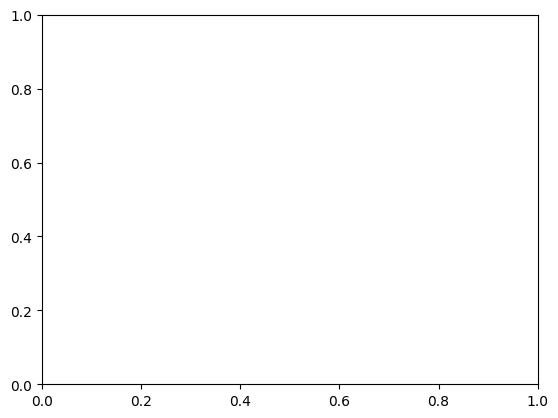

In [21]:
ax = plt.subplot()
sns.lineplot(df_grouped, x="n_splats", y="rating", hue="model", ax=ax)
plt.title("MOS per splat budget (Truck dataset)")
ax.set_xticks([117856, 412235, 1093135, 2186270], ["low", "medium", "high", "extended"])
plt.show()

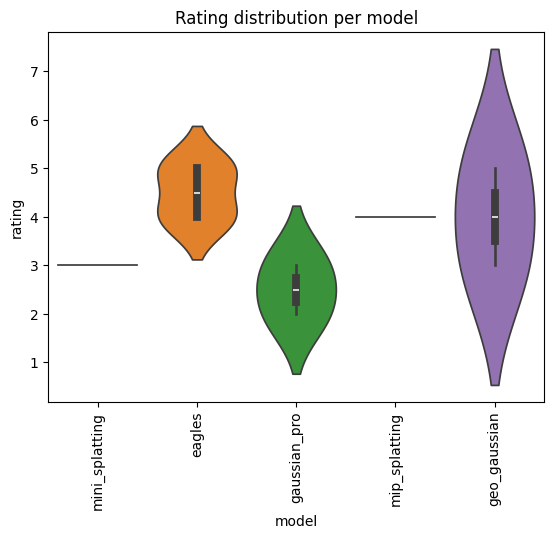

In [96]:
sns.violinplot(df_ratings_truck, x="model", y="rating", hue="model")
plt.title("Rating distribution per model")
plt.xticks(rotation=90)
plt.show()